<a href="https://colab.research.google.com/github/IFES-MPCA/redes_neurais_artificiais/blob/main/keras_classification_multiclass_reuters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Definir semente para reproducibilidade

In [1]:
import numpy
import tensorflow as tf
import random as python_random

SEED = 42
numpy.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

## Carregamento do dataset

In [2]:
from tensorflow.keras.datasets import reuters

(train_x, train_y), (test_x, test_y) = reuters.load_data(num_words=10000)

## Palavras por índice e vice-versa

In [3]:
index_by_word = reuters.get_word_index()
word_by_index = dict([(v, k) for (k, v) in index_by_word.items()])

In [4]:
from typing import List, Dict

def indexes_to_text(word_by_index: Dict[str, int], words_indexes: List[int]) -> str:
    text_words = [
        word_by_index[word_index] if word_index in word_by_index else "*"
        for word_index in words_indexes
    ]
    return " ".join(text_words)

## Tokenização
Etapa para converter uma partição de dados para um array binário, definindo 1 no índice da palavra **(só que usando ferramentas nativas do Keras)**.

In [5]:
from keras.preprocessing.text import Tokenizer

NUM_WORDS = 10_000
tokenizer = Tokenizer(num_words=NUM_WORDS)

# Serão listas de 10k itens. Para cada índice da palavra será definido o valor 1
x_train_tokenized = tokenizer.sequences_to_matrix(train_x)
x_test_tokenized = tokenizer.sequences_to_matrix(test_x)

In [6]:
from typing import Iterable
from numpy import zeros

def to_one_hot(target: Iterable[int]) -> Iterable[bool]:
    dimension = len(set(target))
    results = zeros((len(target), dimension))

    for i, label in enumerate(target):
        results[i, label] = 1
    return results

# Converter as saídas para codificação one-hot
y_train_one_hot = to_one_hot(train_y)
y_test_one_hot = to_one_hot(test_y)

In [7]:
from tensorflow.keras.utils import to_categorical

# Converter a entrada em uma matrix binária, em que o número de linhas é o número de classes
y_train_categorical = to_categorical(train_y)
y_test_categorical = to_categorical(test_y)

## Construção do modelo

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="selu"),
    layers.Dense(128, activation="selu"),
    layers.Dense(46, activation="softmax")
])
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [9]:
percent_val = 0.1
max_index_val = int(percent_val * NUM_WORDS)

x_val = x_train_tokenized[:max_index_val]
partial_x_train = x_train_tokenized[max_index_val:]

y_val = y_train_categorical[:max_index_val]
partial_y_train = y_train_categorical[max_index_val:]

print(f"""x train shape: {partial_x_train.shape}
x validation shape: {x_val.shape}
y train shape: {partial_y_train.shape}
y validation shape: {y_val.shape}""")

x train shape: (7982, 10000)
x validation shape: (1000, 10000)
y train shape: (7982, 46)
y validation shape: (1000, 46)


## Treino e validação

In [10]:
EPOCHS = 20
batch_size = 512
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
history = model.fit(
    partial_x_train, partial_y_train,
    epochs=EPOCHS, batch_size=batch_size,
    validation_data=(x_val, y_val), callbacks=callbacks
)

Epoch 1/20
16/16 [==============================] - 5s 197ms/step - loss: 2.4104 - accuracy: 0.5122 - val_loss: 1.5655 - val_accuracy: 0.6380
Epoch 2/20
16/16 [==============================] - 3s 160ms/step - loss: 1.2320 - accuracy: 0.7271 - val_loss: 1.1560 - val_accuracy: 0.7530
Epoch 3/20
16/16 [==============================] - 1s 89ms/step - loss: 0.8437 - accuracy: 0.8270 - val_loss: 0.9886 - val_accuracy: 0.7960
Epoch 4/20
16/16 [==============================] - 1s 55ms/step - loss: 0.5953 - accuracy: 0.8812 - val_loss: 0.8924 - val_accuracy: 0.8190
Epoch 5/20
16/16 [==============================] - 1s 55ms/step - loss: 0.4216 - accuracy: 0.9154 - val_loss: 0.8435 - val_accuracy: 0.8250
Epoch 6/20
16/16 [==============================] - 1s 54ms/step - loss: 0.3032 - accuracy: 0.9375 - val_loss: 0.8379 - val_accuracy: 0.8260
Epoch 7/20
16/16 [==============================] - 1s 53ms/step - loss: 0.2290 - accuracy: 0.9486 - val_loss: 0.8414 - val_accuracy: 0.8210
Epoch 8/20


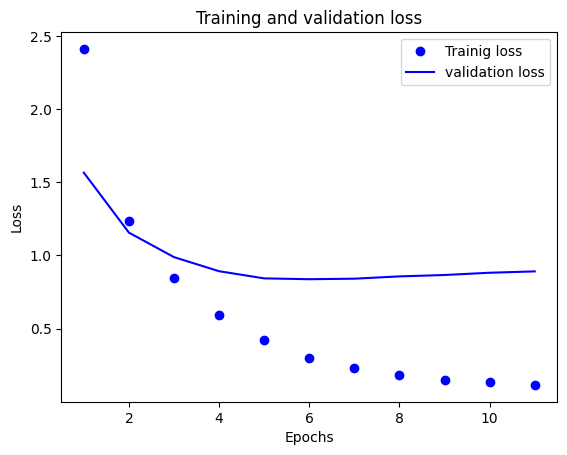

In [11]:
from matplotlib import pyplot

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)

pyplot.plot(epochs, loss_values, "bo", label="Trainig loss")
pyplot.plot(epochs, val_loss_values, "b", label="validation loss")
pyplot.title("Training and validation loss")
pyplot.xlabel("Epochs")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.show()

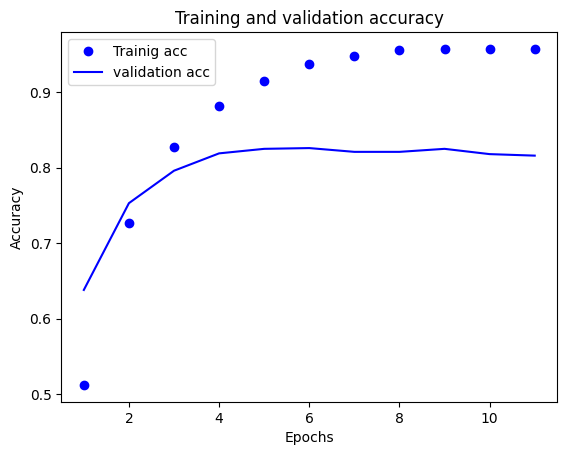

In [12]:
from matplotlib import pyplot

history_dict = history.history
accuracy_values = history_dict["accuracy"]
val_accuracy_values = history_dict["val_accuracy"]
epochs = range(1, len(accuracy_values) + 1)

pyplot.plot(epochs, accuracy_values, "bo", label="Trainig acc")
pyplot.plot(epochs, val_accuracy_values, "b", label="validation acc")
pyplot.title("Training and validation accuracy")
pyplot.xlabel("Epochs")
pyplot.ylabel("Accuracy")
pyplot.legend()
pyplot.show()

## Avaliação (evaluation)

In [13]:
results = model.evaluate(x_test_tokenized, y_test_categorical)

71/71 [==============================] - 0s 4ms/step - loss: 0.9870 - accuracy: 0.8001
